In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
from sklearn.model_selection import train_test_split

In [365]:
columns_list = ['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']

def prepare_data(data):
    data = pd.DataFrame(train,columns=columns_list)
    data['basement_present'] = data['sqft_basement'].apply(lambda x: 1 if x > 0 else 0) # Indicate whether there is a basement or not
    data['renovated'] = data['yr_renovated'].apply(lambda x: 1 if x > 0 else 0) # 1 if the house has been renovated

    data['sqft_living_squared'] = data['sqft_living'].apply(lambda x: x**2)
    data['sqft_living_cubed'] = data['sqft_living'].apply(lambda x: x**3) 
    data['log_sqft_living'] = data['sqft_living'].apply(lambda x: np.log(x))

    data['bedrooms_squared'] = data['bedrooms'].apply(lambda x: x**2) 
    data['bed_bath_rooms'] = data['bedrooms']*data['bathrooms']
    # 分类
    categorial_cols = ['floors', 'view', 'condition', 'grade']
    for cc in categorial_cols:
        dummies = pd.get_dummies(data[cc], drop_first=False)
        dummies = dummies.add_prefix("{}#".format(cc))
        data.drop(cc, axis=1, inplace=True)
        data = data.join(dummies)

    dummies_zipcodes = pd.get_dummies(data['zipcode'], drop_first=False)
    dummies_zipcodes.reset_index(inplace=True)
    dummies_zipcodes = dummies_zipcodes.add_prefix("{}#".format('zipcode'))
    dummies_zipcodes = dummies_zipcodes[['zipcode#98039','zipcode#98004','zipcode#98040','zipcode#98112','zipcode#98102']]
    data.drop('zipcode', axis=1, inplace=True)
    data = data.join(dummies_zipcodes)
    data_arr = np.array(data)
    
    X = np.mat(data_arr[:,3:data.shape[1]],dtype=np.float32)
    y = np.mat(data_arr[:,2:3],dtype=np.float32)
    return X,y


def linear_model(X,W,b):
    return X * W + b


def cost_function(y, h):
    return np.mean(np.power(h - y, 2)) / 2


def gradient_descent(X, y, h,W, b, alpha):
    m = X.shape[0]
    d_W = (X.T * (h - y)) / m
    d_b = np.mean(h - y)
    return (W - alpha * d_W), (b - alpha * d_b)


def normal_equation(X, y):
    theta = (X.T * X).I * X.T * y
    W = theta[1:X.shape[0],0]
    b = theta[0,0]
    return W,b 


def feature_normalize(X):
    stds = np.std(X, axis=0)
    means = np.mean(X, axis=0)
    for c in range(X.shape[1]):
        X[:, c] = (X[:, c] - means[0,c]) / stds[0,c]
    return X,stds,means


def increase_dimension(X,dimension=2):
    X_copy = np.array(X);
    index_arr = np.arange(X.shape[1])
    for d in range(2,dimension+1):
        for c in itertools.combinations(index_arr,d):
            new_feature = np.array(np.ones((X_copy.shape[0],1),dtype=np.float32))
            for i in range(d):
                new_feature = new_feature * X_copy[:,c[i]:c[i]+1]
            X = np.hstack((new_feature,X))
        for f in index_arr:
            new_feature = np.power(X_copy[:,f:f+1],d)
            X = np.hstack((new_feature,X))
    return X


## prepare data

In [366]:
load_data = np.load("kc_house_data.npz")
train = load_data['train']
test = load_data['test']
print(train.shape)
print(test.shape)

train_X,train_y = prepare_data(train)
test_X,test_y = prepare_data(test)

print("train X shape {0},train y shape {1}".format(train_X.shape,train_y.shape))
print("test X shape {0},test y shape {1}".format(test_X.shape,test_y.shape))
print("train X 1:",train_X[0,:])

train_X,train_X_stds,train_X_means = feature_normalize(train_X)
train_y,train_y_stds,train_y_means = feature_normalize(train_y)

for c in range(test_X.shape[1]):
        test_X[:, c] = (test_X[:, c] - train_X_means[0,c]) / train_X_stds[0,c]

test_y_fn = (test_y - train_y_means[0,0]) / train_y_stds[0,0]

(17290, 21)
(4323, 21)
train X shape (21613, 18),train y shape (21613, 1)
test X shape (21613, 18),test y shape (21613, 1)
train X 1: [[  3.00000000e+00   1.00000000e+00   1.18000000e+03   5.65000000e+03
    0.00000000e+00   1.18000000e+03   0.00000000e+00   1.95500000e+03
    0.00000000e+00   4.75112000e+01  -1.22257004e+02   1.34000000e+03
    5.65000000e+03   1.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00]]


epoch: 100,cost: 1.4817797112428701,test_cost: 1.458906507168741
epoch: 200,cost: 0.44164958850221625,test_cost: 0.4379221982368497
epoch: 300,cost: 0.25207821562572036,test_cost: 0.251244828541431
epoch: 400,cost: 0.20389422744200958,test_cost: 0.20363557849932323
epoch: 500,cost: 0.18711074113169177,test_cost: 0.187006361671173
epoch: 600,cost: 0.17979451692337195,test_cost: 0.17974492544471746
epoch: 700,cost: 0.1761614280242644,test_cost: 0.17613562270795582
epoch: 800,cost: 0.17422284578468128,test_cost: 0.17420870723917645
epoch: 900,cost: 0.17314438433271326,test_cost: 0.17313638932811198
epoch: 1000,cost: 0.17252830770171643,test_cost: 0.17252368929983167
epoch: 1100,cost: 0.17216975817595825,test_cost: 0.17216704768284635
epoch: 1200,cost: 0.17195806866494975,test_cost: 0.17195645738303608
epoch: 1300,cost: 0.17183158299449341,test_cost: 0.17183061451388154
epoch: 1400,cost: 0.17175520899094296,test_cost: 0.17175462107271425
epoch: 1500,cost: 0.17170865103628932,test_cost: 0.1

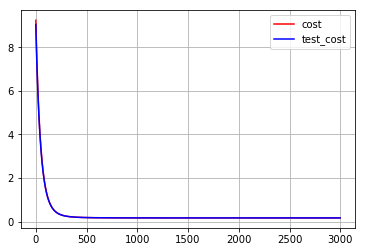

In [367]:
feature_count = train_X.shape[1];
W = np.mat(np.array(np.random.randn(feature_count)).astype(np.float32).reshape(feature_count,1))
b = np.random.randn()

alpha = 0.01
iterations = 3000

step = 100
cost_history = np.mat(np.zeros((iterations,1),dtype=np.float32))
test_cost_history = np.mat(np.zeros((iterations,1),dtype=np.float32))

for epoch in range(iterations):
    h = linear_model(train_X,W,b)
    W,b = gradient_descent(train_X,train_y,h,W,b,alpha)
    
    cost = cost_function(train_y,h)
    test_h = linear_model(test_X,W,b)
    test_cost = cost_function(test_y_fn,test_h)
    cost_history[epoch] = cost
    test_cost_history[epoch] = test_cost

    if (epoch + 1) % step == 0:
        print("epoch: {0},cost: {1},test_cost: {2}".format(epoch + 1, cost,test_cost))

print("finish train!")
h = linear_model(train_X,W,b)    
cost = cost_function(train_y,h)
test_h = linear_model(test_X,W,b)
test_cost = cost_function(test_y_fn,test_h)
print("the end cost: {0},test_cost:{1}".format(cost,test_cost))
plt.plot(range(iterations), cost_history, 'r-', label='cost')
plt.plot(range(iterations), test_cost_history, 'b-', label='test_cost')
plt.grid(True)
plt.legend()
plt.show()

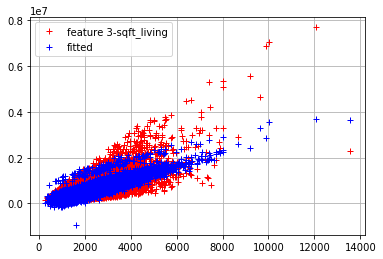

In [368]:
test_X_origin = test_X[:,2]*train_X_stds[0,2]+train_X_means[0,2]

predictions = linear_model(test_X, W, b) * train_y_stds[0,0] + train_y_means[0,0]

plt.plot(test_X_origin, test_y, 'r+', label="feature 3-sqft_living")
plt.plot(test_X_origin, predictions, 'b+', label='fitted')
plt.grid(True)
plt.legend()
plt.show()

## normal equation

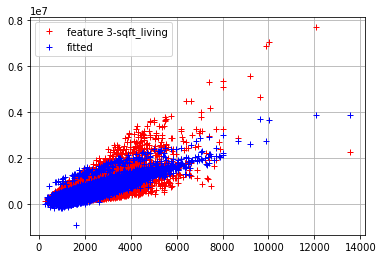

In [369]:
ne_W,ne_b = normal_equation(np.c_[np.ones((train_X.shape[0],1),dtype=np.float32),train_X],train_y)

ne_predictions = linear_model(test_X, ne_W, ne_b) * train_y_stds[0,0] + train_y_means[0,0]

plt.plot(test_X_origin, test_y, 'r+', label="feature 3-sqft_living")
plt.plot(test_X_origin, ne_predictions, 'b+', label='fitted')
plt.grid(True)
plt.legend()
plt.show()